# Impact of aerosols on SED

- Author Sylvie Dagoret-Campagne
- date 10 janvier 2018

Study the impact of aerosols

In [46]:
%load_ext autoreload
%autoreload 2

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.jet
%matplotlib inline

In [48]:
import os
import sys

In [49]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [50]:
top_pysynphot_data_dir=os.environ['PYSYN_CDBS']

In [51]:
sys.path.append('../../libradtransim')
sys.path.append('../../LSSTFiltersKG')
sys.path.append('../../lsstphotometry')
sys.path.append('../../pysynphotsed')

In [52]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst
import libLSSTPhotometry as photo
import libpysynphotsed as sed

In [53]:
import astropy
import astropy.units as u
from astropy.io import fits

In [54]:
import pysynphot as S
S.primary_area=6*1e4
S.binning=10.

# LSST Telescope

In [55]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [56]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [57]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [58]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [59]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [60]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


# Generate one SED according thermal blackbody

In [61]:
Temperature=3500
SigmaT=0.1*Temperature   # T at 20%

In [62]:
all_sed=sed.get_all_thermalbb(N=20,T0=Temperature,sigT=SigmaT)

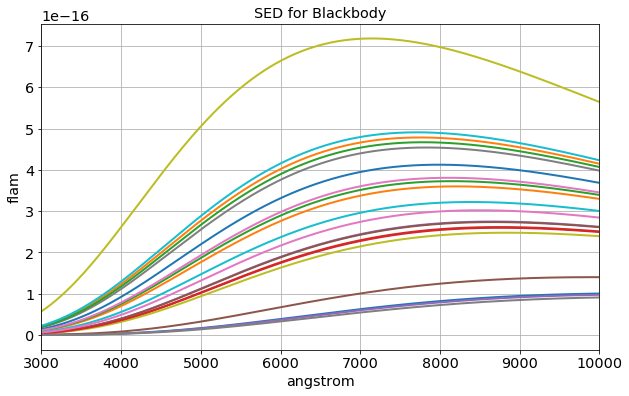

In [63]:
sed.plot_allsed(all_sed,"SED for Blackbody","SED_BB.png",yscale='lin',XMIN=3000.,XMAX=10000.,YMIN=0,YMAX=0)

In [64]:
NBSEDCOLORS=1

# Retrieve Filters

In [65]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('../..')

In [66]:
#lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

# Create LSST Detector

In [67]:
lsstdetector=photo.LSSTTransmission('lssttel')

In [68]:
lsstdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4])

# Simulate Atmosphere

In [69]:
tau_aerosol=np.linspace(0.,0.5,10)
lambda0_aerosol=500. # nm
airmass=1.
pwv=4.0     # mm
ozone=300. # DU

In [70]:
photo_atm=photo.Atmosphere('libradtran')

In [71]:
index=0
for am in range(1,2):
    for tau in tau_aerosol:
        path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau) 
        fullfilename=os.path.join(path,thefile)
        atm_data=np.loadtxt(fullfilename)
        wl_atm=atm_data[:,0]
        tr_atm=atm_data[:,1]  
        if index==0:
            photo_atm.fill_array(wl_atm)        
        photo_atm.fill_array(tr_atm)        
        index+=1

--------------------------------------------
 1) airmass =  1
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  1
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0555555555556
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer5.INP')
('Output to file             

In [72]:
theatmosph=photo_atm.get_array()

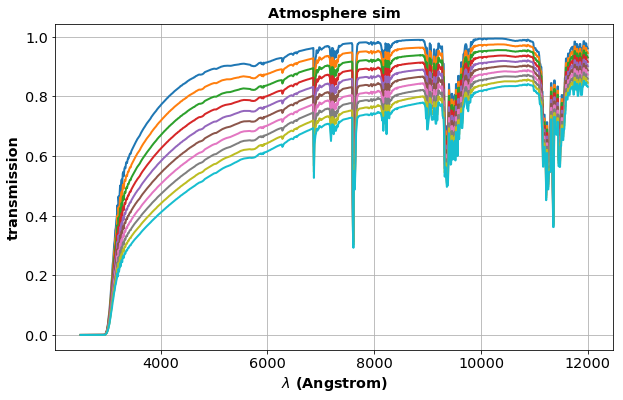

In [73]:
photo_atm.plot_pys_bp()

In [74]:
all_bp_atm=photo_atm.get_pys_pb()

In [75]:
lsstdetector.fill_atm_allevents(all_bp_atm)

In [76]:
all_transmissions=lsstdetector.make_transmissions()

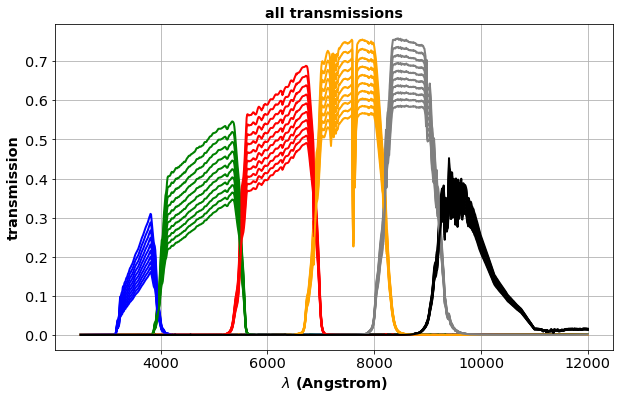

In [77]:
lsstdetector.plot_transmissions()

# Calculation of all Observations for each SED colors

In [78]:
all_observations_collection = []
all_observations_zeropt_collection = []
all_sed=[all_sed]

In [79]:
for starcolor in np.arange(NBSEDCOLORS):
    the_obs_name="libradtran_aerosols-{}".format(sed.TypeStar[starcolor])    
    the_observation=photo.LSSTObservation(the_obs_name)
    the_observation.fill_sed(all_sed[starcolor])
    the_observation.fill_transmission(all_transmissions)
    the_observation.make_observations()
    the_observation.make_samplobservations()
    the_observation.compute_counts()
    the_observation.compute_magnitude()
    zero_pt=the_observation.compute_magnit_zeropt()
    all_observations_zeropt_collection.append(zero_pt)
    all_observations_collection.append(the_observation)

((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_R)) does

((ATM_7 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_Z)) does

((ATM_3 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_U)) doe

((ATM_10 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_Z)) 

((ATM_8 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_G)) d

In [80]:
StarColorSelect=0

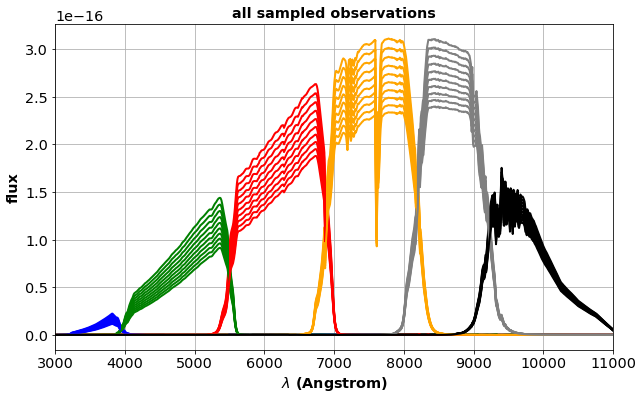

In [81]:
all_observations_collection[StarColorSelect].plot_samplobservations(0)

In [82]:
rt_observations=all_observations_collection[StarColorSelect]
NBSED=len(all_sed[StarColorSelect])
all_zeropt=all_observations_zeropt_collection[StarColorSelect]

In [83]:
def ShowColorBias(rt_observations,NBSED,title,figname):
    for ised in np.arange(NBSED):
        for ifilt in np.arange(photo.NBBANDS-1):
            mag1=rt_observations.get_magnitudeforfilternum(ised,ifilt)
            mag2=rt_observations.get_magnitudeforfilternum(ised,ifilt+1)
            thelabel=photo.number_to_band[ifilt]+'-'+photo.number_to_band[ifilt+1]
            deltamag=mag1-mag2 - (mag1[0]-mag2[0])
            if(ised==0):
                plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1,label=thelabel)
            else:
                plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1)
    plt.plot([tau_aerosol[0],tau_aerosol[-1]],[0.005,0.005],'k:',lw=3)
    plt.title(title,weight='bold')
    plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
    plt.ylabel("$\Delta$ col (mag)",weight='bold')
    plt.legend(loc=2)
    plt.grid()
    plt.savefig(figname)    

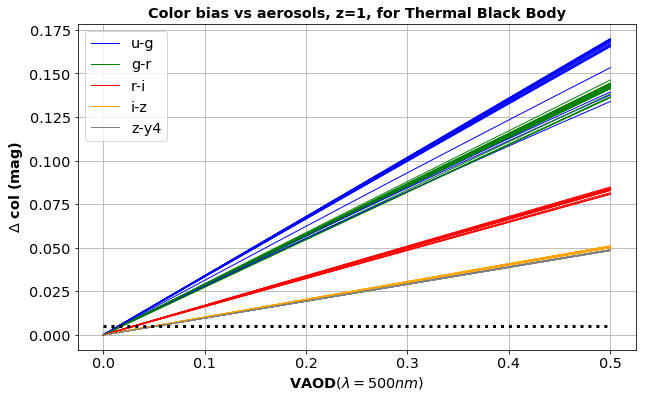

In [84]:
StarColorSelect=0
ShowColorBias(all_observations_collection[StarColorSelect],len(all_sed[StarColorSelect]),"Color bias vs aerosols, z=1, for Thermal Black Body",'Aer_ColorBias1z_Thermal_BB.png')

In [85]:
def ShowColorBias_forZeropt(all_zeropt,NBSED,title,figname):
    for ifilt in np.arange(photo.NBBANDS-1):
        deltamag0pt_1=all_zeropt[:,ifilt]-all_zeropt[0,ifilt]
        deltamag0pt_2=all_zeropt[:,ifilt+1]-all_zeropt[0,ifilt+1]
        deltamag0pt=deltamag0pt_1-deltamag0pt_2
        thelabel=photo.number_to_band[ifilt]
        plt.plot(tau_aerosol,deltamag0pt,color=photo.filtercolor[ifilt],lw=2,label=thelabel)
    plt.title(title,weight='bold')
    plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
    plt.ylabel("Magnitude - Zero pt",weight='bold')
    plt.legend(loc=2)
    plt.grid()    
    plt.savefig(figname)

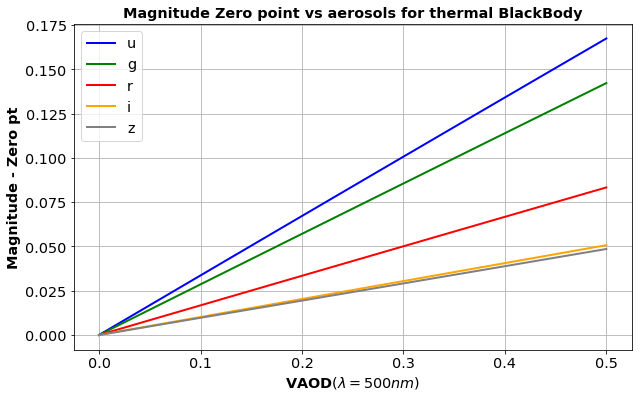

In [86]:
StarColorSelect=0
all_zeropt=all_observations_zeropt_collection[StarColorSelect]
NBSED=len(all_sed[StarColorSelect])
ShowColorBias_forZeropt(all_zeropt,NBSED,"Magnitude Zero point vs aerosols for thermal BlackBody","Aer_ColorBias1z_Thermal_BB_zeropt.png")

In [87]:
def ShowColorBias_ZeroptSubtraction(rt_observations,NBSED,title,figname):
    for ised in np.arange(NBSED):
        for ifilt in np.arange(photo.NBBANDS-1):
            mag1=rt_observations.get_magnitzeroptforfilternum(ised,ifilt)
            mag2=rt_observations.get_magnitzeroptforfilternum(ised,ifilt+1)       
            deltamag= deltamag=mag1-mag2 - (mag1[0]-mag2[0])
            if(ised==0):
                thelabel=photo.number_to_band[ifilt]+'-'+photo.number_to_band[ifilt+1]
                plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1,label=thelabel)
                plt.scatter(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1)
            else:
                plt.plot(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1)
                plt.scatter(tau_aerosol,deltamag,color=photo.filtercolor[ifilt],lw=1)
    plt.title(title,weight='bold')
    plt.xlabel("VAOD$(\lambda=500nm)$",weight='bold')
    plt.ylabel("Magnitude shift",weight='bold')
    plt.legend(loc=2)
    plt.plot([tau_aerosol[0],tau_aerosol[-1]],[0.005,0.005],'k:',lw=2)
    plt.plot([tau_aerosol[0],tau_aerosol[-1]],[-0.005,-0.005],'k:',lw=2)
    plt.grid()
    plt.savefig(figname)    

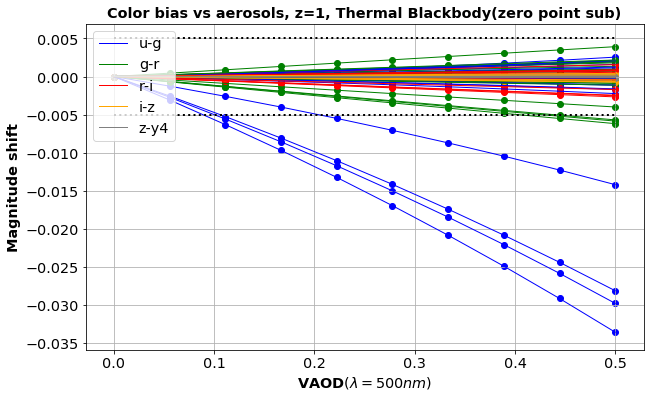

In [88]:
StarColorSelect=0
ShowColorBias_ZeroptSubtraction(all_observations_collection[StarColorSelect],len(all_sed[StarColorSelect]),"Color bias vs aerosols, z=1, Thermal Blackbody(zero point sub)",'Aer_ColorBias1z0ptsub_Thermal_BB.png')

In [89]:
def ShowColorTrajectory(rt_observations,NBSED,Index_Start,xlabel,ylabel,title,figname):
    #Index_Start=0
    Index_Stop=Index_Start+3
    
    ColorDiff=np.zeros([2,NBSED,len(tau_aerosol)])
    x= tau_aerosol
    for i in range(len(x)):
        c = cmap(int(np.rint(x[i] / x.max() * 255)))

    norm = mpl.colors.Normalize(vmin=x.min(), vmax=x.max())

    fig = plt.figure(figsize=(12, 12))    
    
    for ised in np.arange(NBSED):
        for ifilt in np.arange(Index_Start,Index_Stop-1):
            ColorIndex=ifilt-Index_Start
            mag1=rt_observations.get_magnitzeroptforfilternum(ised,ifilt)
            mag2=rt_observations.get_magnitzeroptforfilternum(ised,ifilt+1)
            deltamag= deltamag=mag1-mag2 - (mag1[0]-mag2[0])
            ColorDiff[ColorIndex,ised,:]=deltamag

    for ised in np.arange(NBSED):
        i=0
        for tau in tau_aerosol:
            c = cmap(int(np.rint(x[i] / x.max() * 255)))
            plt.plot(ColorDiff[0,ised,i],ColorDiff[1,ised,i],'o', markersize=20, mfc=c, mec=c)
            i+=1    
            
    plt.plot([-0.005,0.005],[0.005,0.005],'k:',lw=2)
    plt.plot([-0.005,0.005],[-0.005,-0.005],'k:',lw=2)
    plt.plot([0.005,0.005],[-0.005,0.005],'k:',lw=2)
    plt.plot([-0.005,-0.005],[-0.005,0.005],'k:',lw=2)
    
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    rect = 0.91,0.1,0.02,0.8   #  4-length sequence of [left, bottom, width, height] quantities.     
    ax1 = fig.add_axes(rect,label='VAOD$(\lambda=500nm)$')
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    cb1.set_label('VAOD$(\lambda=500nm)$', rotation=270)
    plt.savefig(figname)      

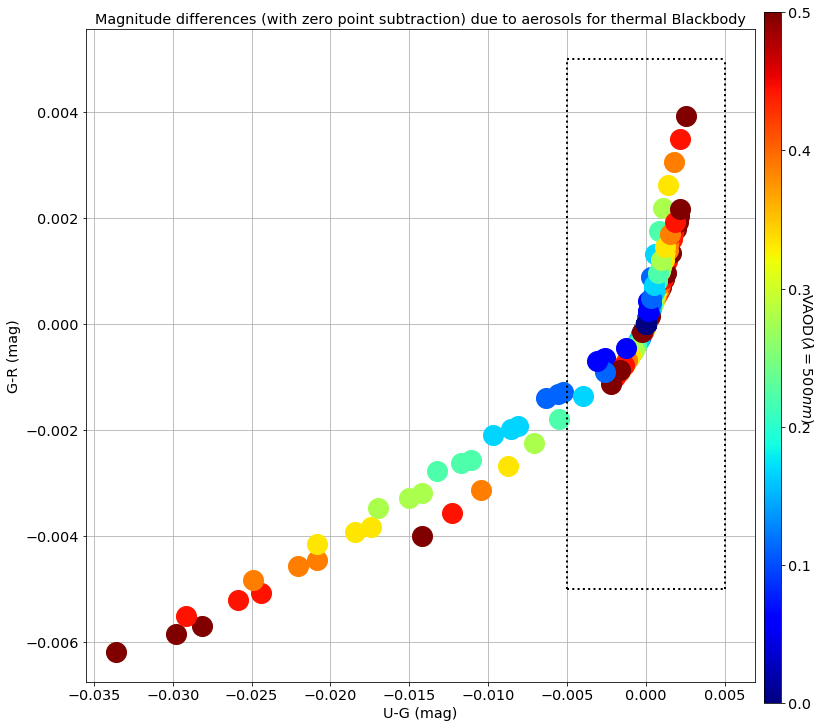

In [90]:
StarColorSelect=0
ShowColorTrajectory(all_observations_collection[StarColorSelect],len(all_sed[StarColorSelect]),0,"U-G (mag)","G-R (mag)","Magnitude differences (with zero point subtraction) due to aerosols for thermal Blackbody",'Aer_ColorBias1z0pt2COLORSsub_Thermal_BB.png')